#Facenet Semantic Dictionaries using Lucid and Svelte
This code is used to both generate the sprite maps and create the dictionaries for individual images.
A web interactable version is created and hosted on the demo website.
Svelte functionality maybe limited to just Google Colab.

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Install / Import / Load

In [ ]:
!pip install --quiet lucid==0.3.8
!npm install -g svelte-cli@2.2.0

import numpy as np
import tensorflow as tf

import lucid.modelzoo.vision_models as models
import lucid.optvis.render as render
from lucid.misc.io import show, load
from lucid.misc.io.showing import _image_url
import lucid.scratch.web.svelte as lucid_svelte

     |████████████████████████████████| 71kB 4.9MB/s 
     |████████████████████████████████| 81kB 4.6MB/s 
     |████████████████████████████████| 1.2MB 14.9MB/s 
/tools/node/bin/svelte -> /tools/node/lib/node_modules/svelte-cli/bin.js
+ svelte-cli@2.2.0
added 2 packages from 1 contributor in 1.229s


# Semantic Dictionary Code

In [ ]:
%%html_define_svelte SemanticDict

<div class="figure">
    <div class="input_image">
        <div class="image" style="background-image: url({{image_url}}); z-index: -10;"></div>
        <svg class="pointer_container" viewBox="0 0 {{N[0]}} {{N[1]}}">

            {{#each xs as x}}
            {{#each ys as y}}
              <rect x={{x}} y={{y}} width=1 height=1
                class={{(x == pos[0] && y == pos[1])? "selected" : "unselected"}}
                on:mouseover="set({pos: [x,y]})"></rect>
            {{/each}}
            {{/each}}
        </svg>
    </div>
    <div class="dict" >
        {{#each present_acts as act, act_ind}}
        <div class="entry">
            <div class="sprite" style="background-image: url({{spritemap_url}}); width: {{sprite_size}}px; height: {{sprite_size}}px; background-position: -{{sprite_size*(act.n%sprite_n_wrap)}}px -{{sprite_size*Math.floor(act.n/sprite_n_wrap)}}px; --info: {{act.n}};"></div>
            <div class="value" style="height: {{sprite_size*act.v/2.0}}px;"></div>
        </div>
        {{/each}}
    </div>
</div>


<style>
    .figure {
        padding: 10px;
        width: 1024px;
    }
    .input_image {
        display: inline-block;
        width: 160px;
        height: 160px;
    }
    .input_image .image, .input_image .pointer_constainer {
        position: absolute;
        width: 160px;
        height: 160px;
        border-radius: 8px;
    }
    .pointer_container rect {
      opacity: 0;
    }
    .pointer_container .selected {
      opacity: 1;
      fill: none;
      stroke: hsl(24, 100%, 50%);
      stroke-width: 0.1px;
    }
    
    .dict {
        height: 128px;
        display: inline-block;
        vertical-align: bottom;
        padding-bottom: 64px;
        margin-left: 64px;
    }
    .entry {
        margin-top: 9px;
        margin-right: 32px;
        display: inline-block;
    }
    .value {
        display: inline-block;
        width: 32px;
        border-radius: 8px;
        background: #777;
    }
    .sprite {
        display: inline-block;
        border-radius: 8px;
    }
    .dict-text {
        display: inline-block;
        font-size: 24px;
        color: #AAA;
        margin-bottom: 20px;
    }
</style>

<script>
    
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        spritemap_url: "",
        sprite_size: 64,
        sprite_n_wrap: 1e8,
        image_url: "",
        activations: [[[{n: 0, v: 1}]]],
        pos: [0,0]
      };
    },
    computed: {
      present_acts: (activations, pos) => activations[pos[1]][pos[0]],
      N: activations => [activations.length, activations[0].length],
      xs: (N) => range(N[0]),
      ys: (N) => range(N[1])
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /tmp/svelte_a9s5t7ta/SemanticDict_cc71dd8c_fe49_4e68_91bf_069b218e8a1c.html > /tmp/svelte_a9s5t7ta/SemanticDict_cc71dd8c_fe49_4e68_91bf_069b218e8a1c.js
b'svelte version 1.64.1\ncompiling ../tmp/svelte_a9s5t7ta/SemanticDict_cc71dd8c_fe49_4e68_91bf_069b218e8a1c.html...\n'



In [ ]:
from lucid.modelzoo.vision_base import Model

class FaceNet(Model):
  model_path = '/content/drive/MyDrive/facenet_converted.pb'
  image_shape = [160, 160, 3]
  image_value_range = (0, 1)
  input_name = 'input'


facenet = FaceNet()
facenet.load_graphdef()


In [ ]:
import json



In [ ]:
def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    return y

In [ ]:

def facenet_semantic_dict(layer, img_url):
    img = load(img_url)
    image_pil = Image.open(img_url)
    image_array = np.asarray(image_pil)
    whitened = prewhiten(image_array)
    
    # Compute the activations
    with tf.Graph().as_default(), tf.Session():
        t_input = tf.placeholder(tf.float32, [160, 160, 3])
        T = render.import_model(facenet, t_input, t_input)
        acts = T(layer).eval({t_input: img})[0]
    



    # Find the most interesting position for our initial view
    max_mag = acts.max(-1)
    max_x = np.argmax(max_mag.max(-1))
    max_y = np.argmax(max_mag[max_x])
    
    # print(acts.shape)
    # print(max_mag)
    # print(max_x)
    # print (max_y)


    # print("ACT")
    activations =  [[[{"n": int(n), "v": float(act_vec[n])} for n in np.argsort(-act_vec)[:4]] for act_vec in act_slice] for act_slice in acts]

    with open('jakeacts.json', 'w') as fp:
      json.dump(activations, fp)


    print(activations)
    # print(len(activations))
    # print(len(activations[0]))
    # print(len(activations[0][0]))
    # print(len(activations[0][0][0]))
    # for ac in activations:
    #   for att in ac:
    #     print(att)

    spritemap = load("/content/Mixed_6a_fullcopy.jpg")

    # Actually construct the semantic dictionary interface
    # using our *custom component*
    lucid_svelte.SemanticDict({
        "spritemap_url": "https://i.imgur.com/1vVqpfQ.jpg",
        "sprite_size": 128,
        "sprite_n_wrap": 28,
        "image_url": _image_url(img),
        "activations": [[[{"n": int(n), "v": float(act_vec[n])} for n in np.argsort(-act_vec)[:4]] for act_vec in act_slice] for act_slice in acts],
         "pos" : [int(max_y), int(max_x)]
    })

In [ ]:
facenet_semantic_dict("InceptionResnetV1/Mixed_6a/concat", "/content/mingcroppedcopy.png")

In [ ]:
facenet_semantic_dict("InceptionResnetV1/Mixed_6a/concat", "/content/ethancropped.jpg")

[[[{'n': 534, 'v': 1.1936841011047363}, {'n': 638, 'v': 1.0991913080215454}, {'n': 593, 'v': 1.005778431892395}, {'n': 200, 'v': 0.6522244215011597}], [{'n': 534, 'v': 1.0425879955291748}, {'n': 593, 'v': 0.8646978139877319}, {'n': 881, 'v': 0.6302967667579651}, {'n': 698, 'v': 0.6103712916374207}], [{'n': 534, 'v': 0.8981897830963135}, {'n': 484, 'v': 0.7618547677993774}, {'n': 698, 'v': 0.6455830335617065}, {'n': 881, 'v': 0.6302967667579651}], [{'n': 302, 'v': 1.4853993654251099}, {'n': 200, 'v': 0.6544705629348755}, {'n': 534, 'v': 0.6505606174468994}, {'n': 881, 'v': 0.6448887586593628}], [{'n': 134, 'v': 0.8204602003097534}, {'n': 20, 'v': 0.7156192660331726}, {'n': 881, 'v': 0.6693243980407715}, {'n': 81, 'v': 0.6189524531364441}], [{'n': 134, 'v': 0.759995698928833}, {'n': 881, 'v': 0.6693243980407715}, {'n': 20, 'v': 0.5867844223976135}, {'n': 150, 'v': 0.56449955701828}], [{'n': 534, 'v': 1.0353479385375977}, {'n': 698, 'v': 0.8181138634681702}, {'n': 754, 'v': 0.642967343330

NotFoundError: ignored


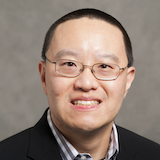

In [ ]:
facenet_semantic_dict("InceptionResnetV1/Mixed_6a/concat", "/content/mingcroppedcopy.png")

In [ ]:
facenet_semantic_dict("InceptionResnetV1/Mixed_6a/concat", "/content/jake.jpeg")

[[[{'n': 5, 'v': 1.0838674306869507}, {'n': 638, 'v': 1.0582422018051147}, {'n': 534, 'v': 0.9780580997467041}, {'n': 81, 'v': 0.7416661977767944}], [{'n': 534, 'v': 1.1405000686645508}, {'n': 593, 'v': 0.7306782007217407}, {'n': 5, 'v': 0.6800299286842346}, {'n': 881, 'v': 0.6518493890762329}], [{'n': 534, 'v': 1.026824712753296}, {'n': 180, 'v': 0.6801866292953491}, {'n': 881, 'v': 0.6556058526039124}, {'n': 828, 'v': 0.5020608305931091}], [{'n': 534, 'v': 0.9346129894256592}, {'n': 881, 'v': 0.6531631946563721}, {'n': 159, 'v': 0.6080264449119568}, {'n': 81, 'v': 0.572014331817627}], [{'n': 534, 'v': 0.9263365268707275}, {'n': 881, 'v': 0.6531631946563721}, {'n': 159, 'v': 0.5350208282470703}, {'n': 828, 'v': 0.49871134757995605}], [{'n': 52, 'v': 0.6449163556098938}, {'n': 534, 'v': 0.6410360336303711}, {'n': 881, 'v': 0.6294655203819275}, {'n': 25, 'v': 0.6157675385475159}], [{'n': 534, 'v': 0.8365540504455566}, {'n': 593, 'v': 0.8037363290786743}, {'n': 379, 'v': 0.73495513200759

NotFoundError: ignored

In [ ]:
from lucid.misc.io.serialize_array import _normalize_array as normalize_array
from PIL import Image
from matplotlib.pyplot import imshow
import math
import lucid.optvis.objectives as objectives

In [ ]:
def get_pil_image( array ):
    img = Image.fromarray( normalize_array( array ) )
    img.load()
    return img

In [ ]:
vis = render.render_vis(facenet, "InceptionResnetV1/Mixed_6a/concat:638", thresholds=(512,), verbose=False)

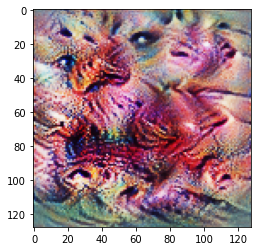

In [ ]:
pil_img = get_pil_image( np.hstack( vis ) )

imshow(np.asarray(pil_img))


##Code for generating layer 6A spritemap

In [ ]:
scale = 128
cols = 28
rows = 32


spritemap_size = ( scale * cols, scale * rows )
spritemap = Image.new( "RGB", spritemap_size)

In [ ]:
spritemap = Image.open("/content/drive/MyDrive/spritemaps/Mixed_6a_728.png")

In [ ]:
def add_sprite( spritemap=None, sprite=None, size=( 128, 128 ), cols=1, index=0 ):

    image_width, image_height = sprite.size
    
    tile_width, tile_height = size
    
    top = tile_height * math.floor( index / cols )
    left = tile_width * ( index % cols )

    box = ( left, top )
    box = [ int(i) for i in box ]

    try:
        spritemap.paste( sprite, box )
    except Exception as e:
        print( "Error pasting sprite: box=[{}]; {}".format( box, e ) )
        raise e

In [ ]:
add_sprite(spritemap, pil_img, cols = 28, index = 638 )

spritemap.save("/content/drive/MyDrive/spritemaps/Mixed_6a_" + str(35) +".png" , "PNG")

In [ ]:
C = lambda neuron: objectives.channel(*neuron)

def generate_map():
  for i in range(728, 896):
    print(i)
    vis = render.render_vis(facenet, C( ("InceptionResnetV1/Mixed_6a/concat",i)) , thresholds=(512,), verbose=False)
    pil_img = get_pil_image( np.hstack( vis ) )
    add_sprite(spritemap, pil_img, cols = 28, index = i)
    if i % 28 == 0:
      display(spritemap)
      spritemap.save("/content/drive/MyDrive/spritemaps/Mixed_6a_" + str(i) +".png" , "PNG")

In [ ]:
generate_map()

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
spritemap.save("/content/drive/MyDrive/spritemaps/Mixed_6a_" + "final" +".png" , "PNG")